<a href="https://colab.research.google.com/github/alouwyck/vives-machine-learning/blob/main/10_decision_trees/1_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

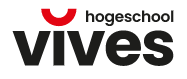<br>


**MACHINE LEARNING FUNDAMENTALS**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# **DECISION TREES - PART I**

Deze notebook is gebaseerd op hoofdstuk 9 van het handboek "Grokking Machine Learning (version 12)" van Luis Serrano (2020). De notebook werd opgesteld in samenwerking met Dr. Stefaan Haspeslagh, onderzoeker en lector AI aan de Vives Hogeschool.

## Inleiding

Een **decision tree** of **beslissingsboom** is een veelgebruikt en zeer veelzijdig machine learning model. Voordat we decision trees introduceren, even een kleine herhaling.

Tot nu toe hebben we drie verschillende **machine learning taken** gezien:
- regressie
- classificatie
- clustering

Daarnaast hebben we een aantal **machine learning modellen** gezien voor bovenstaande taken. We geven telkens aan welk model bij welke taak hoort:
- lineaire regressie: regressie
- polynomiale regressie : regressie
- perceptron: classificatie (en regressie)
- logistische regressie: classificatie
- k-nearest neighbors: classificatie (en regressie)
- k-means: clustering

Voor elk type model hebben we een **machine learning algoritme** gezien om het model te trainen. Het resultaat van dat algoritme is het machine learning model. Bij lineaire en polynomiale regressie en bij perceptron en logistische regressie, bijvoorbeeld, hebben we het **stochastic gradient descent** algoritme toegepast om de parameters van het model te optimaliseren.

In dit hoofdstuk behandelen we decision trees of beslissingsbomen. Decision trees zijn dus zeer veelzijdig en kunnen gebruikt worden voor zowel regressie, classificatie als voor clustering. Hier beperken we ons tot met decision trees voor classificatie, ook wel **classification trees** genoemd.

In deze notebook komen volgende topics aan bod:

- Wat is een decision tree?
- Hoe een decision tree bouwen?
    - Wat is information gain, gini index en accuracy?
    - Hoe die metrieken te gebruiken om een goede classifier te bouwen?
    - Wat is het algoritme om een decision tree model te trainen?
- Hoe een decision tree evalueren?
- Voorbeelden

## Wat is een decision tree?

We leggen eerst uit wat een tree is om uiteindelijk tot de definitie van ee decision tree te komen.

### Wat is een tree?

Een boom of **tree** is een niet lineaire datastructuur. Een tree stelt een hiërarchische relatie voor: de knopen of **nodes** in een tree hebben één ouder of **parent**. Hier bestaat één uitzondering op: de wortel of **root** van de tree heeft geen parent. Nodes kunnen eventueel ook kinderen of **children** hebben. Nodes in een tree die geen children hebben, noemen we bladen of **leaves**.

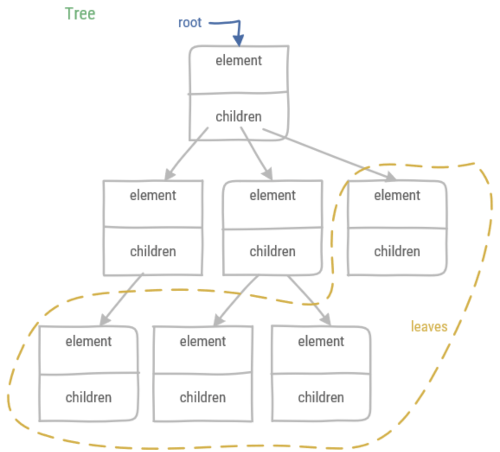

### Wat is de instance space?

De ***instance space*** is de verzameling van alle instanties die kunnen voorkomen als je alle combinaties van alle waarden van alle features beschouwt. Niet elke combinatie hoeft voor te komen in de data set. De training-, test- en validatieset zijn deelverzamelingen van de instance space.

**Voorbeeld**

Beschouw een dataset met twee feature, 'gender' en 'adult'. Beide features kunnen twee waarden aannemen, er zijn dus 4 mogelijke instanties. De volledige instance space is:

| nr | gender | adult |
| --- | --- | --- |
| 1 | F | no |
| 2 | F | yes |
| 3 | M | no |
| 4 | M | yes |

In Python kunnen we eenvoudig alle combinaties creëren met de functie `product` uit module `itertools`, want wat we hier eigenlijk willen is het cartesisch product van `gender` en `adult` (zie SQL):

In [ ]:
gender = ["F", "M"]
adult = ["no", "yes"]

from itertools import product

for instance in product(gender, adult):
    print(instance)

('F', 'no')
('F', 'yes')
('M', 'no')
('M', 'yes')


Stel $F_k$ gelijk aan de verzameling verschillende waarden die feature $k$ kan aannemen. In het algemeen is de grootte van de instance space $I$ voor $k$ features dan:

> $|I| = |F_1| \times |F_2| \times ... \times |F_k|$

Als daar een numerieke feature inzit, dan is dit een *oneindige* verzameling, omdat er oneindig veel getallen zijn.

Een ***instance segment*** van de instance space is een deel van de instance space waar de waarde van één of meerdere features vastgezet is.

Hieronder een voorbeeld van een instance segment staat in de tabel hieronder. De waarde van gender werd op 'F' vastgezet.

| nr | gender | adult |
| --- | --- | --- |
| 1 | F | no |
| 2 | F | yes |

In Python:

In [ ]:
for instance in product(gender[0], adult):
    print(instance)

('F', 'no')
('F', 'yes')


### Wat is een decision tree?

Een decision tree wordt soms ook wel een *feature tree* genoemd:

- de interne nodes zijn gelabeld met een feature;
- elke node wordt gesplitst op de verschillende waarden die de feature in die node kan aannemen;
- elk blad van de feature tree is een segment van de instance space (want elke split in een node deelt de instance space op in een aantal segmenten die in een volgende node opnieuw gesplitst kunnen worden).

Dat klinkt nogal abstract, maar wat hier juist bedoeld wordt zal duidelijk worden nadat we zelf een decision tree hebben opgesteld adhv een dataset.

### Hoe werkt een decision tree bij classificatie?

In wat volgt zien we vooral voorbeelden van **binaire beslissingsbomen**, waarin de features telkens twee waarden kunnen aannemen (ja/nee, waar/vals, 0/1, spam/ham, ...). We gebruiken dus een decision tree voor **supervised learning**, en meer bepaald voor **classificatie**, want we hebben gelabelde instanties (examples of voorbeelden), waarvoor we op basis van de features het juiste label proberen te voorspellen.



In een decision tree wordt de instance space gesplitst per node. Er duiken hierbije enkele vragen op:
- *Welke feature gebruiken we in de eerste node om een eerste opsplitsing te maken?*
- *Hoe kunnen we inschatten dat een opsplitsing in een node (en dus een keuze voor een feature) een goede keuze is?*
- *Wanneer moeten we ophouden met opsplitsen? M.a.w. wanneer zijn we in een leaf (blad) beland?*
- *Moeten we alle features gebruiken in een decision tree?*
- *Mag een feature meerdere keren gebruikt worden?*
- ...


We gaan op zoek naar het antwoord op bovenstaande vragen en starten met een heel simpel algoritme:

1. Neem de **meest determinerende feature** en splits de data op basis van deze feature.
2. Baseer de finale voorspelling op deze **split**, of neem de volgende **meest determinerende feature** en herhaal 1.

We voeren dit algoritme even uit op een heel eenvoudig probleem. Je wil beslissen of je een jas zal dragen om naar buiten te gaan. Waarop baseer je je beslissing? Je kijkt bijvoorbeeld of het regent. Als het regent, draag je zeker een jas. Als het niet regent is het antwoord op de vraag niet duidelijk. M.a.w. je hebt meer informatie nodig om je beslissing op te baseren. Een tweede parameter kan temperatuur zijn: als het warm is buiten draag je geen jas, maar als het koud is, dan draag je zeker een jas. Dit beslissingsproces is weergegeven op de volgende figuur.

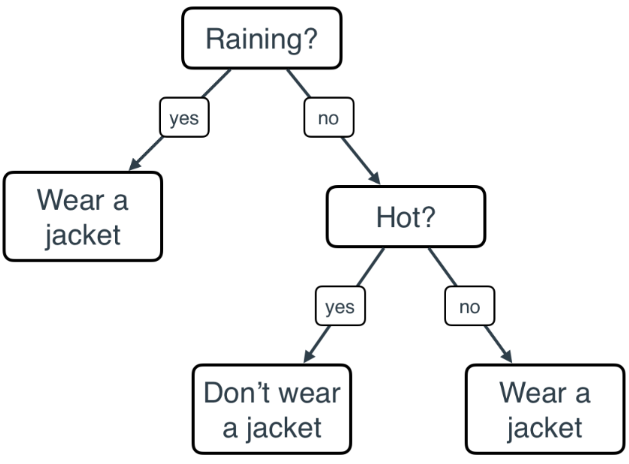

Dit is een eerste voorbeeld van een beslissingsboom. In de eerste node, de **root**, gebruik je de feature 'Raining?'. Is het antwoord op die vraag 'yes', dan kom je in een **leaf** van de boom terecht. In een leaf kan je een beslissing nemen. Hier is die beslising: 'Wear a jacket'. Is het antwoord op diezelfde vraag 'no', dan kom je in een **subtree** terecht, met als eerste node/feature 'Hot?'.
Die tweede 'subboom' resulteert in twee bladeren, waar je dus een finale beslissing kan nemen. Wordt da vraag 'Hot?' met 'yes' beantwoordt, dan is de beslissing 'Don't wear a jacket'. Is het antwoord 'no', dan is de beslissing 'Wear a jacket'.

Bovenstaande boom is slecht één voorbeeld van een mogelijke beslissingboom om de vraag 'Wear jacket?' te beantwoorden. Hieronder een tweede boom:

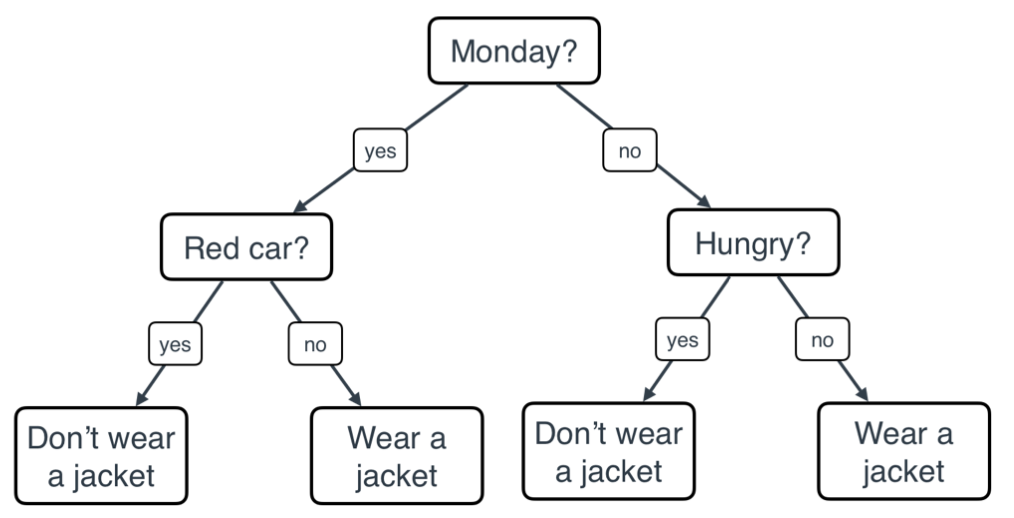

Deze boom ziet er complexer uit dat de eerste zoekboom. De eerste node splitst op de vraag: 'Monday?'. Als het maandag is, dan kies je 'yes'. Dit is de linkertak van de boom, die een nieuwe vraag stelt: 'Red car?'. Die 'subboom' resulteert in twee bladeren: als er een rode auto buiten staat, dan is het antwoord 'yes', en dan is de beslissing 'Don't wear a jacket'. Als er geen rode auto buiten staat, dan is het antwoord 'no' en de beslissing 'Wear a jacket'.

De rechtertak van de wortel is ook een nieuwe boom, met als vraag 'Hungry?'. Die boom heeft ook twee bladeren die leiden tot de volgende beslissingen: als je honger hebt, dan draag je geen jas, heb je echter geen honger, dan draag je wel een jas.

Welke boom prefereer je nu? De eerste of de tweede boom? Uiteraard de eerste boom. Mensen kunnen deze keuze snel maken: de eerste boom bevat relevante vragen om het probleem op te lossen, en is bovendien minder complex. Maar hoe kan een computer deze keuze maken? Een computer heeft enkel data ter beschikking en zal de juiste boom moeten kiezen gebaseerd op deze data.

Een eerste mogelijkheid is dat we alle mogelijke beslissingsbomen opstellen, en die boom eruit pikken die de beste performantie geeft op de data, m.a.w. de beste voorspellingen maakt. Het is echter computationeel niet haalbaar om dit te doen. We gebruiken slimme algoritmen om de zoektocht naar een goede boom sneller te laten verlopen. We overlopen de stappen in het algoritme die nodig zijn om een decision tree te vinden.

### Hoe een decision tree opstellen?

Om een beslissingsboom op te stellen moet er eerst een feature geselecteerd woden. Dat komt neer op het vinden van een goede eerste vraag om de eerste opsplitsing in de instance space te maken.

Stel dat er vijf mogelijke vragen zijn:

1. Regent het buiten?
2. Is het warm buiten?
3. Heb ik honger?
4. Staat er een rode auto voor de deur?
5. Is het vandaag maandag?


Die laatste drie vragen zijn duidelijk irrelevant, en dat is ook de reden waarom de tweede boom die we gezien hebben waardeloos is. De keuze gaat dus tussen de eerste twee vragen. Stel dat we het volgende experiment opgesteld hebben:

- In jaar 1 beslissen we of we een jas dragen op basis van de neerslag.
- In jaar 2 beslissen we of we een jas dragen op basis van de temperatuur.

We tellen telkens in hoeveel gevallen we een juiste beslissing genomen hebben, nl. dat we een jas aangetrokken hebben wanneer het echt nodig was. We bekomen de volgende gegevens:

- In jaar 1 hebben we 250 keer de juiste beslissing genomen.
- In jaar 2 hebben we 220 keer de juiste belissing genomen.

Vraag 1 is dus duidelijk de betere vraag op basis van deze gegevens. We maken daarom de volgende initiële beslissingsboom:

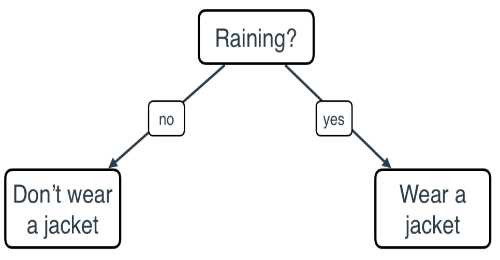

De root van de boom bevat de vraag of het regent: 'Raining?'. De takken zijn bepaald door de mogelijke antwoorden op die vraag: 'no' of 'yes'. In de bladeren wordt vervolgens een beslissing genomen: als het regent beslis je een jas te dragen, anders beslis je om geen jas te dragen.

**Kunnen we deze boom nog verbeteren?**

In de rechter tak kunnen we de beslissing moeilijk verbeteren, want we weten uit ervaring dat het goed is om een jas te dragen als het regent! We kunnen er dus vanuit gaan dat de beslissing in deze tak behoorlijk *accuraat* is.

Maar de linker tak is niet *accuraat*: als het niet regent, dragen we dan nooit een jas? Natuurlijk niet, want we weten uit ervaring dat, indien het koud is, het nodig is om een jas te dragen, zelfs als het niet regent! We kunnen er dus niet zeker van zijn dat we in de meeste gevallen de juiste beslissing nemen in die tak. Integendeel, vaak zullen we hier een foute beslissing nemen door nooit een jas te dragen!

**Hoe lossen we dit op?**

In de boom hierboven gebruiken we slechts één vraag, terwijl we nog een relevante tweede vraag ter beschikking hebben. In plaats van een definitieve beslissing te nemen in het linker blad, gebruiken we beter een extra vraag om de kans op een juiste beslissing in dat blad te verhogen. Dit resulteert in de volgende beslissingsboom:

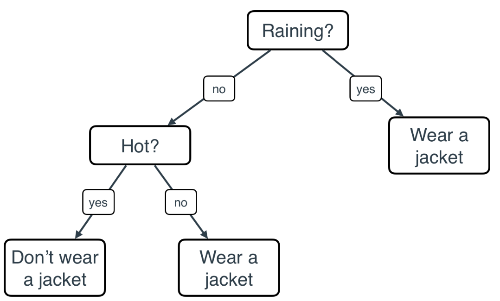

Het linkerblad is nu veranderd in een nieuwe beslissingsboom, met als vraag of het warm is: 'Hot?'.

Kunnen we nu nog beter doen? Misschien, als we nog meer bladeren veranderen in subtrees, of als we de volgorde van de vragen in de boom veranderen. Maar op dit ogenblik nemen we genoegen met de boom die we gevonden hebben met het simpele algoritme dat we hierboven gedefinieerd hebben. We herhalen dit algoritme hier voor de volledigheid:

1. Neem de **meest determinerende feature** en splits de data op basis van deze feature.
2. Baseer de finale beslissing op deze **split**, of neem de volgende **meest determinerende feature** en herhaal stap 1.

Tot nu toe hebben we onze intuïtie gebruikt om de beste feature of de beste vraag in een node te kiezen. In de volgende sectie bespreken we hoe een computer die keuze kan maken.

## Majority class labeling

### Dataset: a recommendation system to choose an app.

Stel dat we een appstore wil ontwikkelen voor smartphones (zoals Google Play op Android of App Store van Apple). In feite is dat een recommender system dat aan een gebruiker de juiste app voorstelt om te downloaden en te installeren.

Omdat we ergens moeten beginnen, starten we met een zeer kleine appstore met drie applicaties:
- *Atom Count*: een app om het aantal atomen in je lichaam te tellen.
- *Beehive Finder*: een app om de dichtsbijzijnde bijenkorf te vinden.
- *Check Mate*: een app om schaakspelers in je buurt te vinden.

We hebben ook de volgende gegevens van gebruikers die eerder één van die apps geïnstalleerd heeft:

| gender | age | app |
| --- | --- | --- |
| F | 15 | atom |
| F | 25 | check |
| M | 32 | beehive |
| F | 35 | check |
| M | 12 | atom |
| M | 14 | atom |

Die data vind je ook terug in het bestand 'appstore.csv'. Lees de data in als Pandas DataFrame `df`.

In [ ]:
import pandas as pd

df = pd.read_csv('appstore.csv', sep=";")
df

,gender,age,app
0,F,15,atom
1,F,25,check
2,M,32,beehive
3,F,35,check
4,M,12,atom
5,M,14,atom


Om het probleem niet nodeloos complex te maken willen we met binaire features werken. In het appstore probleem zijn er twee features en één label. De feature "gender" is in deze dataset binair, dus daar hoeven we niets aan te wijzigen. De feature "age" is niet binair en dus moeten we een transformatie uitvoeren op die feature. We bestempelen mensen die jonger zijn dan 20 jaar als "young" en mensen van 20 jaar en ouder noemen we "adult".

Voer nu die datatransformatie uit op de dataframe `df` zodat de kolom `age` ook een binaire feature wordt.

In [ ]:
transform_age_to_binary = lambda x : 'young' if (x < 20) else 'adult'

df['age'] = df['age'].transform(transform_age_to_binary)
df

,gender,age,app
0,F,young,atom
1,F,adult,check
2,M,adult,beehive
3,F,adult,check
4,M,young,atom
5,M,young,atom


### De beste vraag 'berekenen'

Als we een decision tree willen opstellen, dan moeten we een eerste 'beste' vraag kiezen. Voor onze dataset zijn er twee mogelijke vragen:

1. Is de gebruiker mannelijk of vrouwelijk?
2. Is de gebruiker jong of oud?

We willen nu gaan 'berekenen' welke vraag het best gebruikt wordt in de root van de decision tree. Laten we de twee opties uittesten.

Voor de eerste vraag krijgen we de volgende split:

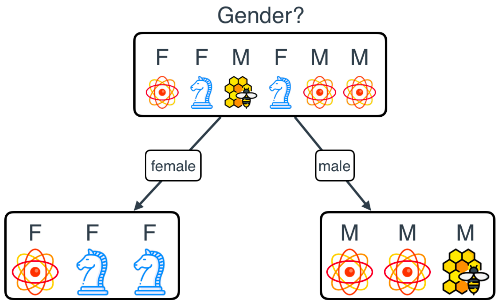

In Python:

In [ ]:
for value in df.gender.unique():
    print(df[df.gender == value])

  gender    age    app
0      F  young   atom
1      F  adult  check
3      F  adult  check
  gender    age      app
2      M  adult  beehive
4      M  young     atom
5      M  young     atom


We krijgen dus het volgende resultaat in de bladeren van de decision tree:
- 2 vrouwelijke gebruikers hebben "check" en 1 heeft "atom" gedownload.
- 2 mannelijke gebruikers hebben "atom" en 1 heeft "beehive" gedownload.

Voor de tweede vraag krijgen we de volgende split:

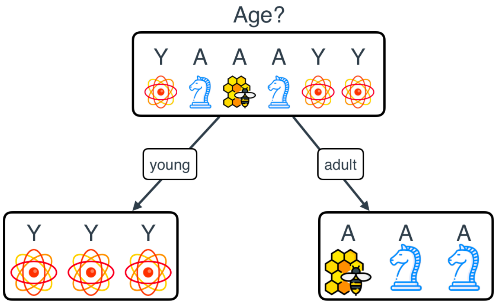

In Python:

In [ ]:
for value in df.age.unique():
    print(df[df.age == value])

  gender    age   app
0      F  young  atom
4      M  young  atom
5      M  young  atom
  gender    age      app
1      F  adult    check
2      M  adult  beehive
3      F  adult    check


We hebben het volgende resultaat in de bladeren van de tweede decision tree:
- *alle* jonge gebruikers downloaden "atom".
- 2 volwassen gebruikers downloaden "check", één downloadt "beehive".

### Welke beslissing neem je in een blad?

We hebben twee bomen opgesteld, telkens met 1 node en 2 bladeren. Maar we hebben nog niet bepaald welke beslissing (of welke voorspelling) er genomen moet worden in de bladeren.

Een veel gebruikte techniek is om te kijken naar welke klasse het meest voorkomt in de voorbeelden die we in een blad aantreffen. We voorspellen dan als label gewoon de klasse die het meest voorkomt in het blad. We noemen dit **majority class labelling**.

Voor de eerste boom wordt dat dan:
- in het linkerblad voorspellen we 'check'.
- in het rechterblad voorspellen we 'atom'.

Voor de tweede boom:
- in het linkerblad voorspellen we 'atom'.
- in het rechterblad voorspellen we 'check'.

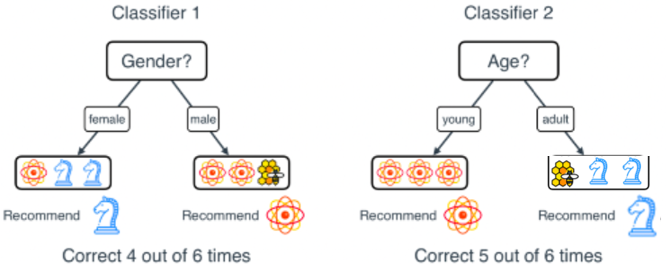

We kunnen nu beide 'classifiers' met elkaar vergelijken:

* Classifier 1 is 4 op de 6 keer correct:
  - We voorspellen in het linkerblad 'check', wat juist is in twee gevallen.
  - We voorspellen in het rechterblad 'atom', wat juist is in twee gevallen.
  - Conclusie: op de 6 gevallen zijn er dus in totaal 4 juiste voorspellingen.

* Classifier 2 is 5 op de 6 keer correct:
  - We voorspellen in het linkerblad 'atom', wat juist is in drie gevallen.
  - We voorspellen in het rechterblad 'check', wat juist is in twee gevallen.
  - Conclusie: op de 6 gevallen zijn er dus in totaal 5 juiste voorspellingen.

In Python:

In [ ]:
nsamples = len(df)  # aantal examples
label = 'app'  # label: we voorspellen de app
for feature in ['gender', 'age']:  # de 2 features overlopen
    print(feature)
    correct = 0  # hou het aantal correcte voorspellingen per feature bij
    for value in df[feature].unique():  # de mogelijke values van feature overlopen
        sub = df[df[feature] == value]  # subset met alle examples waarvoor feature gelijk is aan value
        counts = sub[label].value_counts()  # tel het aantal labels
        m, i = counts.max(), counts.argmax()  # neem het label dat het meest voorkomt
        prediction = counts.index[i]  # voorspel het label dat het meest voorkomt
        print(value, '->', prediction)
        correct += m  # update het aantal correcte voorspellingen
    print('correct:', correct, '/', nsamples, '\n')

gender
F -> check
M -> atom
correct: 4 / 6 

age
young -> atom
adult -> check
correct: 5 / 6 



Boom 2 lijkt dus de betere keuze te zijn! Maar natuurlijk willen we *metrieken* hebben om deze keuze te rechtvaardigen, zodat een computer tot dezelfde conclusie kan komen!

## Metrieken om te splitsen

We bespreken volgende metrieken:
- *accuracy*
- *gini impurity index*
- *gini gain*
- *entropy*
- *information gain*

We illustreren deze metrieken aan de hand van de volgende fictieve dataset:

| gender | age | location | app |
| --- | --- | --- | --- |
| F | young | A | 1 |
| M | young | A | 1 |
| F | young | A | 1 |
| M | adult | A | 1 |
| F | young | B | 2 |
| M | adult | B | 2 |
| F | adult | B | 2 |
| M | adult | B | 2 |


Als Pandas DataFrame:

In [ ]:
data = pd.DataFrame(
    dict(
         gender=   ['F', 'M'] * 4,
         age=      ['young'] * 3 + ['adult', 'young'] + ['adult'] * 3,
         location= ['A'] * 4 + ['B'] * 4,
         app=      [1] * 4 + [2] * 4
         )
)
data

,gender,age,location,app
0,F,young,A,1
1,M,young,A,1
2,F,young,A,1
3,M,adult,A,1
4,F,young,B,2
5,M,adult,B,2
6,F,adult,B,2
7,M,adult,B,2


We kunnen de dataset splitsen volgens 3 mogelijke features: gender, age en location. De drie mogelijke splits worden weergegeven op de volgende figuur:

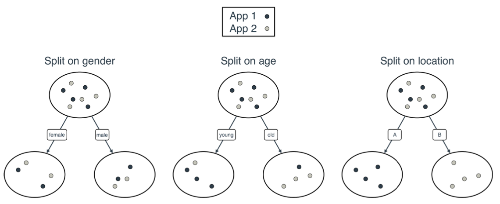

In Python:

In [ ]:
for feature in ["gender", "age", "location"]:
    print(feature)
    for value in data[feature].unique():
        print(data[data[feature] == value])
    print()

gender
  gender    age location  app
0      F  young        A    1
2      F  young        A    1
4      F  young        B    2
6      F  adult        B    2
  gender    age location  app
1      M  young        A    1
3      M  adult        A    1
5      M  adult        B    2
7      M  adult        B    2

age
  gender    age location  app
0      F  young        A    1
1      M  young        A    1
2      F  young        A    1
4      F  young        B    2
  gender    age location  app
3      M  adult        A    1
5      M  adult        B    2
6      F  adult        B    2
7      M  adult        B    2

location
  gender    age location  app
0      F  young        A    1
1      M  young        A    1
2      F  young        A    1
3      M  adult        A    1
  gender    age location  app
4      F  young        B    2
5      M  adult        B    2
6      F  adult        B    2
7      M  adult        B    2



De resultaten zijn samengevat in onderstaande tabel. De kolommen betekenen het volgende:
- 1L = aantal keer app 1 in Linkerblad
- 2L = aantal keer app 2 in Linkerblad
- 1R = aantal keer app 1 in Rechtblad
- 2R = aantal keer app 2 in Rechtblad

| split | 1L | 2L | 1R | 2R |
| --- | --- | --- | --- | --- |
| gender | 2 | 2 | 2 | 2 |
| age | 3 | 1 | 1 | 3 |
| location | 4 | 0 | 0 | 4 |

In Python:

In [ ]:
label = 'app'  # label = we voorspellen 'app'
split = dict()  # aantal bijhouden in dict 'split'
LR = ['L', 'R']  # list met 'L' en 'R' nodig voor de kolomnamen in de tabel
for feature in ['gender', 'age', 'location']:  # features overlopen
    split[feature] = dict()  # aantallen bijhouden in 'feature' subdict
    for i, value in enumerate(data[feature].unique()):  # tabel opsplitsen adhv feature value
        sub = data[data[feature] == value]  # subdataframe
        for app in data[label].unique():  # labels overlopen (app)
            key = str(app) + LR[i]  # kolomnaam (key in subdict)
            split[feature][key] = (sub[label] == app).sum()  #  # aantal x dat app voorkomt

split = pd.DataFrame(split).T  # dict omzetten naar dataframe
split

,1L,2L,1R,2R
gender,2,2,2,2
age,3,1,1,3
location,4,0,0,4


### Accuracy

De nauwkeurigheid of **accuracy** van een model kennen we natuurlijk al. Herinner je de definitie:

> $accuracy = \frac{\#\textrm{correcte voorspellingen}}{\textrm{totaal aantal voorspellingen}}$

We kunnen dus voor de bladeren van een decision tree (want daar vinden we de voorspellingen terug) de accuracy berekenen adhv *majority class labeling*.

Voor de split op "gender":
- de accuracy in het linkerblad is (als we als beslissing app 1 kiezen): $\frac{2}{4} = 0.5$
- de accuracy in het rechterblad is (als we als beslissing app 2 kiezen): $\frac{2}{4} = 0.5$
- de accuracy van de classifier is dus: $\frac{0.5 + 0.5}{2} = 0.5$

Voor de split op "age":
- de accuracy in het linkerblad is: $\frac{3}{4} = 0.75$
- de accuracy in het rechterblad is: $\frac{3}{4} = 0.75$
- de accuracy van de classifier is dus: $\frac{0.75+ 0.75}{2} = 0.75$

Voor de split op "location":
- de accuracy in het linkerblad is: $\frac{4}{4} = 1$
- de accuracy in het rechterblad is: $\frac{4}{4} = 1$
- de accuracy van de classifier is dus: $\frac{1 + 1}{2} = 1$

De splits zijn samengevat op de volgende figuur. Het is duidelijk dat de beste split op "location" is!

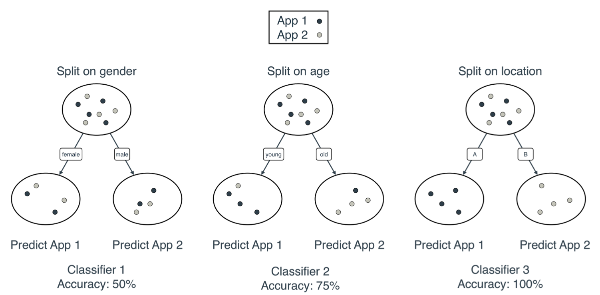

In Python:

In [ ]:
acc = [split[columns].max(axis=1) / split[columns].sum(axis=1)  # acc voor L en R
       for columns in [['1L', '2L'], ['1R', '2R']]]
(acc[0] + acc[1]) / 2  # gemiddelde acc

gender      0.50
age         0.75
location    1.00
dtype: float64

We weten ondertussen al dat we moeten opletten met de accuracy, en dus gaan we op zoek naar betere metrieken.

### Gini impurity index

De resultaten die we hebben verkregen adhv de accuracy doen vermoeden dat hoe homogener de voorspellingen in de leaves zijn na een split, hoe beter die split is.

We willen dus een metriek die de **homogeniteit** van een split uitdrukt. We introduceren daarom de **impurity index**:
- Hoe heterogener een set is, hoe meer verschillende elementen er in die set zitten, en dus hoe hoger de impurity index is.
- Hoe homogener een set is, hoe meer dezelfde elementen er in die set zitten, en dus hoe lager de impurity index is.

De impurity index die we bekijken is meer bepaald de **Gini impurity index**, die een maat is voor de diversiteit in een verzameling.

We maken de analogie met verzamelingen van ballen met een bepaalde kleur. Een voorbeeld is gegeven op de volgende figuur:



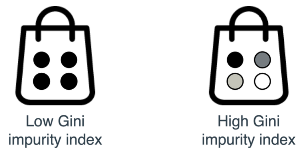

Links op de figuur staat een verzameling van 4 zwarte ballen. Rechts op de figuur staat een verzameling ballen die allemaal een verschillende kleur hebben. We willen dus dat de Gini impurity index van de linker verzameling laag is, en dat de rechter verzameling een hoge index heeft. Om hier een concreet getal op te kunnen plakken, passen we het begrip kans of **probabiliteit** toe.

We kijken dus naar de kans dat, als we twee ballen uit een verzameling nemen, die ballen een verschillende kleur hebben:
- Als de verzameling een lage Gini impurity index heeft, dan zijn de meeste ballen van dezelfde kleur, en dan is de kans om twee ballen van verschillende kleur te trekken laag.
- Als de verzameling een hoge Gini impurity index heeft, dan zijn de meeste ballen van verschillende kleur, en dan is de kans om twee ballen van verschillende kleur te trekken hoog.

Om dit te illustreren, berekenen we deze kans voor 5 verschillende verzamelingen ballen:

- *Set 1*: {black, black, black, black}
- *Set 2*: {black, black, black, white}
- *Set 3*: {black, black, white, white}
- *Set 4*: {black, white, white, white}
- *Set 5*: {white, white, white, white}


*Set 1*

In set 1 zijn er geen witte ballen, dus de kans om 2 ballen van verschillende kleur te trekken is dus 0. Dat is makkelijk!

*Set 2*

In set 2 zijn er drie zwarte ballen en 1 witte bal. Er zijn in totaal 16 verschillende manieren om twee ballen te trekken (we leggen de ballen terug in dit experiment!). De 16 mogelijkheden zijn weergegeven op onderstaande figuur en in onderstaande tabel:

## 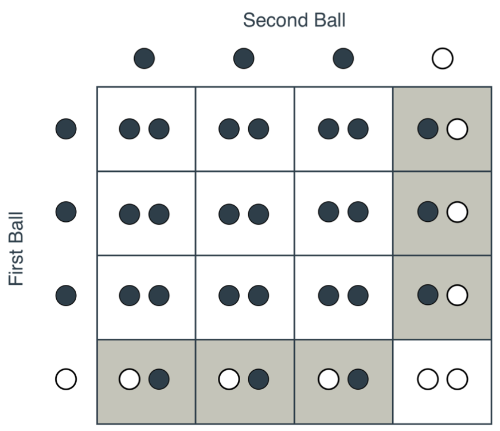

| nr | bal 1 | bal 2 | zelfde kleur? |
| --- | --- | --- | --- |
| 1 | zwart |  zwart | ja |
| 2 | zwart |  zwart | ja |
| 3 | zwart |  zwart | ja |
| 4 | zwart |  wit | nee |
| 5 | zwart |  zwart | ja |
| 6 | zwart |  zwart | ja |
| 7 | zwart |  zwart | ja |
| 8 | zwart |  wit | nee |
| 9 | zwart |  zwart | ja |
| 10 | zwart |  zwart | ja |
| 11 | zwart |  zwart | ja |
| 12 | zwart |  wit | nee |
| 13 | wit | zwart | nee |
| 14 | wit | zwart | nee |
| 15 | wit | zwart | nee |
| 16 | wit | wit | ja |

In 6 van de 16 gevallen hebben we dus twee ballen van verschillende kleur! De Gini impurity index is dus $\frac{6}{16} = 0.375$.

*Set 3*

Hier hebben we ook 16 mogelijkheden, weerom weergegeven in een figuur en een tabel.

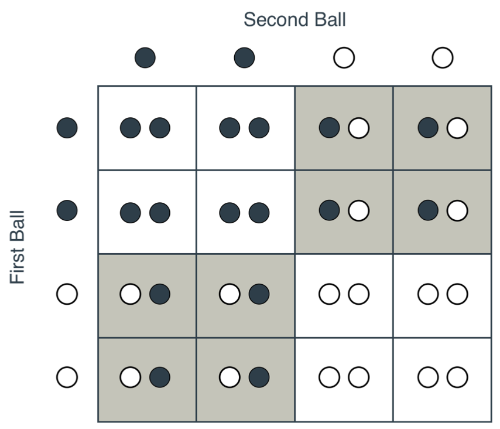

| nr | bal 1 | bal 2 | zelfde kleur? |
| --- | --- | --- | --- |
| 1 | zwart |  zwart | ja |
| 2 | zwart |  zwart | ja |
| 3 | zwart |  wit | nee |
| 4 | zwart |  wit | nee |
| 5 | zwart |  zwart | ja |
| 6 | zwart |  zwart | ja |
| 7 | zwart |  wit | nee |
| 8 | zwart |  wit | nee |
| 9 | wit |  zwart | nee |
| 10 | wit |  zwart | nee |
| 11 | wit |  wit | ja |
| 12 | wit |  wit | ja |
| 13 | wit | zwart | nee |
| 14 | wit | zwart | nee |
| 15 | wit | wit | ja |
| 16 | wit | wit | ja |

In 8 van de 16 gevallen hebben we twee ballen van verschillende kleur! De Gini impurity index is dus $\frac{8}{16} = 0.5$.

*Set 4*

Als je in set 4 de zwarte ballen vervangt door witte en de witte ballen door zwarte, dan krijg je set 2. Set 4 is als het ware het 'spiegelbeeld' (of het complement) van set 2 en heeft daarom dezelfde Gini impurity index gelijk aan 0.375.

*Set 5*

Set 5 is natuurlijk het 'complement' van set 1: er slechts 1 soort ballen, en dus is de Gini impurity index ook gelijk aan 0.

**Formule voor Gini impurity index**

Samengevat willen we dus de kans berekenen dat we 2 ballen van verschillende kleur trekken uit een verzameling, waarbij we de getrokken bal telkens terugleggen.



We bekijken eerst de complementaire gebeurtenis, nl: wat is de kans dat we twee ballen van dezelfde kleur trekken?

We nemen als voorbeeld set 2:

- de kans dat we twee zwarte ballen trekken is: $\frac{3}{4}.\frac{3}{4} = \frac{9}{16}$
- de kans dat we twee witte ballen trekken is: $\frac{1}{4}.\frac{1}{4} = \frac{1}{16} $
- in totaal is de kans dat we twee ballen van dezelfde kleur trekken dus: $\frac{9}{16}+\frac{1}{16} = \frac{10}{16}$
- De kans dat we twee ballen van verschillende kleur (verschillende labels!) trekken is dan: $1 - \frac{10}{16} = \frac{6}{16} = 0.375$



In het algemeen:
- Stel dat we $N$ ballen hebben, die $l$ kleuren kunnen aannemen.
- Stel dat we $a_i$ ballen hebben van kleur $i$.
- We weten dan dat $a_1 + a_2 + ... + a_l = N$.
- De kans dat we een bal van kleur $i$ trekken is dan $p_i = \frac{a_i}{N}$.
- De kans dat we twee ballen van kleur $i$ trekken is dan $p_i^2$.
- De kans dat we twee ballen van dezelfde kleur trekken is dan: $p_1^2 + p_2^2 + ... + p_l^2 = \sum_{i=1}^{l}p_i^2$.
- De kans dat we twee ballen van verschillende kleur trekken is tenslotte: $1 - p_1^2 - p_2^2 - ... - p_l^2 = 1 - \sum_{i=1}^{l}p_i^2$.


We gieten de formule nu in een algemene vorm. Maar eerst enkele definities:

- $D$ is de verzameling van instanties die gesplitst moet worden.

- Het aantal instanties in verzameling $D$ duiden we aan met $|D|$.

- De instanties in $D$ worden beschreven door een willekeurig aantal features.

- Eén feature is de target die we willen voorspellen, en die bevat $l$ verschillende waarden (klassen).

- Het aantal instanties van type $i$ in $D$ is $a_i$ met $1 \leq i \leq l$. Of anders gezegd, $a_i$ is het aantal instanties die behoren tot klasse $i$.

- De kans $p_i$ om een instantie van type $i$ te trekken uit $D$ is $p_i = \frac{a_i}{|D|}$.

In de root van de beslissingsboom is $D$ de volledige verzameling van voorbeelden (de volledige dataset of tabel in dit hoofdstuk!). In de andere nodes, is $D$ een deelverzameling (of subtabel) van de verzameling (of tabel) met alle instanties.

**De Gini impurity index van een verzameling $D$ is dan:**

> $gini(D) = 1 - \sum_{i=1}^l{p_i^2}$

Voor **binaire features** ($l=2$) kunnen we deze formule als volgt vereenvoudigen:

> $gini(D) = 1 - p_1^2 - p_2^2$

Aangezien $p_2 = 1 - p_1$:

> $gini(D) = 1 - p_1^2 - (1 - p_1)^2$

> $gini(D) = 1 - p_1^2 - (1 - 2p_1 + p_1^2)$

> $gini(D) = 2p_1 - 2p_1^2$

> $gini(D) = 2p_1(1 - p_1)$

Opnieuw gebruik makend van $p_2 = 1 - p_1$, krijgen we uiteindelijk:

> $gini(D) = 2p_1p_2$

#### Gini gain

De metriek **Gini gain** gebruiken we om te berekenen welke feature we best nemen om de boom te splitsen. We willen dat de labels in de bladeren minder divers (of dus homogener) worden naarmate we dieper in de boom terecht komen. We willen daarom dat de *Gini impurity index* in de bladeren zo laag mogelijk is.



We geven weer eerst enkele definities:

- Een verzameling instanties $D$ wordt op basis van een feature $f$ gesplitst in een aantal disjuncte deelverzamelingen $D_1$, $D_2$, ... $D_k$, met $k$ het aantal verschillende waarden die de feature $f$ kan aannemen.

- Elke disjuncte deelverzameling $D_i$ bevat $|D_i|$ elementen met $0 \leq |D_i| \leq |D|$.


Zowel van de verzameling $D$ als van de deelverzamelingen $D_i$ kan de Gini impurity index berekend worden.

We definiëren nu de Gini gain op een verzameling $D$ volgens een feature $f$ alst:

> $ginigain(D, f) = gini(D) - \sum_{i=1}^k\frac{|D_i|}{|D|}gini(D_i)$

Merk op dat $\sum_{i=1}^k\frac{|D_i|}{|D|}gini(D_i)$ het gewogen gemiddelde is van de Gini impurity indices van de deelverzamelingen $D_i$.

We nemen het gewogen gemiddelde omdat de deelverzamelingen $D_i$ niet hetzelfde aantal instanties hebben. Daarom nemen we als gewichten de relatieve grootte $\frac{|D_i|}{|D|}$ van de deelverzamelingen. Moesten we dat niet doen, dan zou een verzameling van slechts 1 instantie evenveel doorwegen als een deelverzameling met veel instanties, wat uiteraard geen goed idee is.

Voor elke feature kunnen we zo de Gini gain berekenen. We verkiezen dan de feature met de hoogste Gini gain, omdat die de laagste gewogen gemiddelde Gini impurity index heeft. Het is deze feature die we nemen om onze boom verder op te splitsen.

**Voorbeeld**

Die definities zijn nogal abstract en zien er ook indrukwekkend uit, dus laten we eens een eenvoudig voorbeeldje geven op basis van de 'appstore' dataset waarop we daarnet al de accuracy hebben toegepast.

| gender | age | location | app |
| --- | --- | --- | --- |
| F | young | A | 1 |
| M | young | A | 1 |
| F | young | A | 1 |
| M | adult | A | 1 |
| F | young | B | 2 |
| M | adult | B | 2 |
| F | adult | B | 2 |
| M | adult | B | 2 |

We berekenen nu voor elke feature de Gini gain.


*Feature Gender*

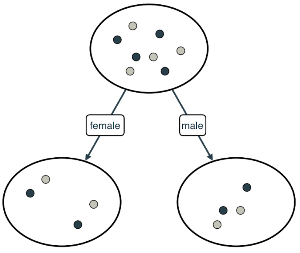

Als we de dataset splitsen op "gender", dan hebben we:

- in de linker tak, met waarde "female": 2 keer app 1 en 2 keer app 2
- in de rechter tak met waarde "male": 2 keer app 1 en 2 keer app 2

Aangezien we hier met binaire classificatie te maken hebben, is de Gini impurity index dus gelijk aan $2p_1p_2$. De Gini impurity index is dan:
- voor de wortel: $2\frac{4}{8}\frac{4}{8}=0.5$
- voor het linkerblad: $2\frac{2}{4}\frac{2}{4} = 0.5$
- voor het rechterblad: $2\frac{2}{4}\frac{2}{4} = 0.5$

De gewogen gemiddelde Gini impurity index van de bladeren is dan:
- $\frac{4}{8}0.5 + \frac{4}{8}0.5 = 0.5$

De Gini gain is tenslotte gelijk aan de Gini impurity index van de wortel min de gewogen gemiddelde Gini impurity index van de bladeren: $0.5 - 0.5 = 0$


*Feature Age*

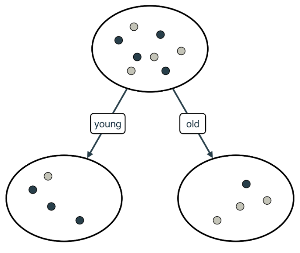

Als we de dataset splitsen op "age", dan hebben we:
- in de linker tak met waarde "young": 3 keer app 1 en 1 keer app 2
- in de rechter tak met waarde "old": 1 keer app 1 en 3 keer app 2

De Gini impurity index voor:
- de wortel: $2\frac{4}{8}\frac{4}{8}=0.5$
- het linkerblad: $2\frac{3}{4}\frac{1}{4} = 0.375$
- het rechterblad: $2\frac{3}{4}\frac{1}{4} = 0.375$

De gewogen gemiddelde Gini impurity index van de bladeren is dan:
- $\frac{4}{8}0.375 + \frac{4}{8}0.375 = 0.375$

De Gini gain is tenslotte: $0.5 - 0.375 = 0.125$


*Feature Location*

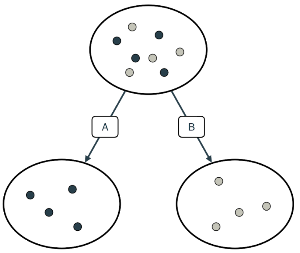

Als we de dataset splitsen op "location", dan hebben we:
- in de linker tak met waarde "A": 4 keer app 1 en 0 keer app 2
- in de rechter tak met waarde "B": 0 keer app 1 en 4 keer app 2

De Gini impurity index voor:
- de wortel: $2\frac{4}{8}\frac{4}{8}=0.5$
- het linkerblad: $2\frac{4}{4}\frac{0}{4} = 0$
- het rechterblad: $2\frac{4}{4}\frac{0}{4} = 0$

De gewogen gemiddelde Gini impurity index van de bladeren is dan:
- $\frac{4}{8}0 + \frac{4}{8}0 = 0$

De Gini gain is tenslotte: $0.5 - 0 = 0.5$

*Conclusie*

Volgens de Gini gain kunnen we best splitsen ahdv feature "location", omdat die de grootste winst of 'gain' in zuiverheid of 'purity' heeft.

##### Opdracht

Schrijf een generieke functie om, gegeven een dataframe, en een label, de Gini gain te berekenen. Test je functie uit op de appstore dataset die je hebt ingelezen als Pandas DataFrame `df`:

In [ ]:
df

,gender,age,app
0,F,young,atom
1,F,adult,check
2,M,adult,beehive
3,F,adult,check
4,M,young,atom
5,M,young,atom


Om de Gini impurity index te berekenen, moeten we weten wat de verschillende labels zijn in een dataset en hoeveel voorbeelden er per label in de dataset zitten.

Schrijf een functie `count_per_label(dataframe, target)` die voor een gegeven dataframe en een target het aantal voorbeelden per mogelijke waarde van de targetkolom berekent. Je geeft een lijst terug met deze aantallen.

Voorbeeld: de uitvoer van `count_per_label(df, 'app')` is `[3, 2, 1]`.

In [ ]:
# count number of different labels in set
def count_per_label(dataframe, target):
    classes = {}
    for element in dataframe[target]:
        if element in classes:
            classes[element] += 1
        else:
            classes[element] = 1
    return [classes[l] for l in classes]

Uittesten op `df` met label `"app"`:

In [ ]:
count_per_label(df, 'app')

[3, 2, 1]

Het kan natuurlijk sneller met de `value_counts` methode van het DataFrame:

In [ ]:
df.app.value_counts()

atom       3
check      2
beehive    1
Name: app, dtype: int64

Schrijf nu een functie `gini_impurity` die voor een dataframe en gegeven target de algemene formule voor de Gini impurity index implementeert.

In [ ]:
def gini_impurity(dataframe, target):
    cts = count_per_label(dataframe, target)
    n = sum(cts)
    return 1 - sum([(a_i/n)**2 for a_i in cts])

Uittesten op `df` met label `"app"`:

In [ ]:
gini_impurity(df, 'app')

0.6111111111111112

Schrijf nu een functie `split_dataframe` om een dataframe op een gegeven feature te splitsen: gegeven een dataframe `df` en een feature met `k` waarden, retourneer een list van `k` dataframes. De waarde van de feature in elke subdataframe is gelijk. M.a.w. de functie splitst dus een dataframe `df` adhv de waarden van een gegeven `feature`, zoals we hierboven al hebben gedaan.

In [ ]:
def split_dataframe(dataframe, feature):
    return [dataframe[dataframe[feature] == value]
            for value in dataframe[feature].unique()]

Uittesten op `df` en feature `'gender'`:

In [ ]:
for sub in split_dataframe(df, 'gender'):
    print(sub)
    print()

  gender    age    app
0      F  young   atom
1      F  adult  check
3      F  adult  check

  gender    age      app
2      M  adult  beehive
4      M  young     atom
5      M  young     atom



We kunnen natuurlijk de Gini impurity index berekenen voor elk van die twee subdatasets:

In [ ]:
for sub in split_dataframe(df, 'gender'):
    print(sub)
    print("gini index =", gini_impurity(sub, target='app'))
    print()

  gender    age    app
0      F  young   atom
1      F  adult  check
3      F  adult  check
gini index = 0.4444444444444444

  gender    age      app
2      M  adult  beehive
4      M  young     atom
5      M  young     atom
gini index = 0.4444444444444444



Implementeer nu een functie `weighted_gini_impurity(split, target)` met:
- `split` een lijst van dataframes (output van functie `split_dataframe`)
- `target` een string met de kolomnaam die de labels bevat

Functie `weighted_gini_impurity` berekent het gewogen gemiddelde van de Gini impurity indices van de verschillende dataframes in de lijst `split`.

In [ ]:
def weighted_gini_impurity(split, target):
    d = sum([len(s) for s in split]) # |D|
    return sum([(len(s) / d) * gini_impurity(s, target) for s in split]) # sum(|D_i|/|D| * gini(D_i))

Uittesten op `df` gesplitst op `"gender"`:

In [ ]:
split = split_dataframe(df, 'gender')
weighted_gini_impurity(split, 'app')

0.4444444444444444

Je hebt nu alle ingrediënten om de Gini gain voor een split te berekenen adhv functie `gini_gain`:

In [ ]:
def gini_gain(dataframe, split, target):
    return gini_impurity(dataframe, target) - weighted_gini_impurity(split, target)

Vervolgens kan je in een functie `get_best_split` een algoritme schrijven dat, gegeven een dataframe, een lijst met features en een target, de feature selecteert met de hoogste Gini gain. Dit is de feature waarop het dataframe zal gesplitst worden.

In [ ]:
def get_best_split(dataframe, features, target):
    result = dict()
    for feature in features:
        split = split_dataframe(dataframe, feature)
        result[gini_gain(dataframe, split, target)] = (feature, split)
    return result[max(result.keys())]

Uittesten op `df` voor features `'age'` en `'gender'` en target `'app'`:

In [ ]:
best_feature, split = get_best_split(df, ['age', 'gender'], 'app')
print(best_feature)
print()
for sub in split:
    print(sub)
    print()

age

  gender    age   app
0      F  young  atom
4      M  young  atom
5      M  young  atom

  gender    age      app
1      F  adult    check
2      M  adult  beehive
3      F  adult    check



### Entropy & Information Gain

Entropy en Information Gain zijn gelijkaardige metrieken als Gini impurity index en Gini gain. Enkel de formules zijn een beetje anders (en iets moeilijker te begrijpen). [Entropie](https://nl.wikipedia.org/wiki/Entropie) is een begrip uit de fysica, en meer bepaald uit de thermodynamica. Eenvoudig gezegd heeft een systeem een lage entropie als het mooi geordend is, terwijl een chaotisch system een hoge entropie heeft. Denk aan een doos met twee soorten knikkers die perfect gescheiden zijn in de doos. Dit is een toestand van minimale entropie. Als je een knikker uit de doos trekt, dan weet je zeker welke soort knikker het zal zijn. Wanneer je nu de doos gaat schudden tot de knikkers volledig door elkaar liggen en niet meer van elkaar gescheiden zijn, dan is de entropie maximaal. Trek je in dat geval een knikker uit de doos, dan heb je 50% kans dat de knikker 1 van de 2 soorten is. Zie je het verband met de analogie van het trekken van ballen die we hebben gebruikt bij het uitleggen van de Gini impurity index?

**Entropy** is dus een andere metriek om de *homogeniteit* van een verzameling in te schatten. We hebben opnieuw een verzameling van instanties $D$, en de target feature $L$ kan $l$ verschillende waarden aannemen. Stel dat er voor elk label $i$, $a_i$ voorbeelden in verzameling $D$ aanwezig zijn, dan is zoals bij de Gini impurity index: $p_i = \frac{a_i}{|D|}$.

Entropy is dan gedefinieerd als:

> $E(D) = -\sum_{i=1}^{l}{p_i\log_2(p_i)}$

Voor binaire features/targets kunnen we die formule opnieuw vereenvoudigen:

> $E(D) = -p_1\log_2(p_1) - p_2\log_2(p_2)$

> $E(D) = -p_1\log_2(p_1) - (1 - p_1)\log_2(1-p_1)$

Let op! De $log_2$ functie betekent de logaritmische fucntie met basis 2 en niet met basis 10 zoals we gewoonlijk gebruiken! Hieronder (linker plot) zie je de grafiek van $log_2(p)$ met $p$ een getal tussen 0 en 1, een kans dus. De $log_2$ van een kans is altijd negatief, en hoe kleiner de kans, hoe kleiner de logaritme van die kans. We nemen echter de negatieve logaritme en vermenigvuldigen met de kans zelf: $-p\log_2(p)$. Op die manier wordt de entropie kleiner naarmate de verzameling homogener wordt.

Check hiervoor de formule van entropy en veronderstel dat je de entropy wil berekenen voor een 'zuivere' of 'homogene' deelverzameling die uit slechts één waarde bestaat. Dan is $p_1$ ofwel 0 ofwel 1, en $p_2 = 1 - p_1$ gelijk aan 1 of 0. In beide gevallen is $E$ gelijk aan nul, wat je mooi kan zien op de rechtergrafiek van de plot hieronder. Dus hoe lager de entropie $E$, hoe beter. Denk terug aan het voorbeeld van de doos met knikkers! Ook hier wil je de verschillende klassen zo goed als mogelijk gescheiden hebben!

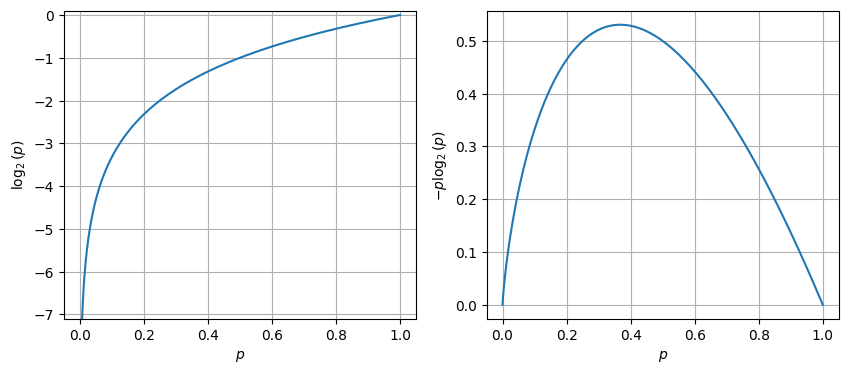

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

p = np.logspace(-5, 0, 1000)

ax1.plot(p, np.log2(p));
ax1.grid();
ax1.set_ylim([-7.1, 0.1])
ax1.set_xlabel('$p$');
ax1.set_ylabel('$\log_2(p)$');

ax2.plot(p, -p * np.log2(p));
ax2.grid();
ax2.set_xlabel('$p$');
ax2.set_ylabel('$-p \log_2(p)$');

Wanneer we nu de Entropy voor een binaire variabele plotten, dan zien we dat die maximaal is wanneer $p_1=p_2=0.5$.

<ipython-input-104-e2619ec226e4>:1: RuntimeWarning: divide by zero encountered in log2
  E = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
<ipython-input-104-e2619ec226e4>:1: RuntimeWarning: invalid value encountered in multiply
  E = -p * np.log2(p) - (1 - p) * np.log2(1 - p)


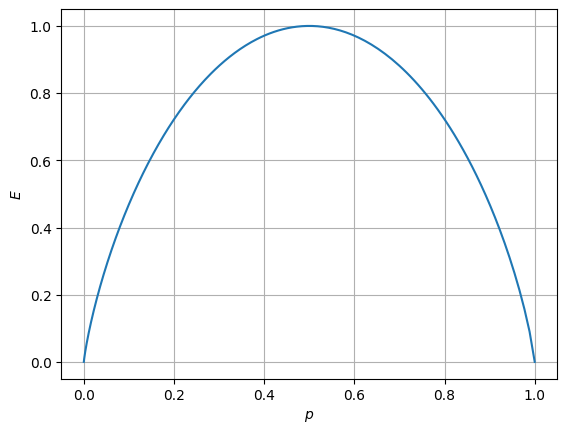

In [ ]:
E = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
E[-1] = 0  # p = 1 gives NaN but should be 0
plt.plot(p, E);
plt.grid();
plt.xlabel('$p$');
plt.ylabel('$E$');

De Information Gain op een verzameling $D$ volgens een feature $f$ kunnen we nu op dezelfde manier als de Gini gain definiëren:

> $\textrm{informationgain}(D, f) = E(D) - \sum_{i=1}^k\frac{|D_i|}{|D|}E(D_i)$

met $k$ het aantal verschillende waarden die de feature $f$ kan aannemen.

De term $\sum_{i=1}^k\frac{|D_i|}{|D|}E(D_i)$ is opnieuw het gewogen gemiddelde van de entropy van de deelverzamelingen $D_i$.

Net als bij de Gini gain selecteren we opnieuw de feature die voor de hoogste information gain zorgt.

**Voorbeeld**

Laten we ook hier eens de formules toepassen op de 'appstore' dataset om te tonen hoe we die juist moeten berekenen.

*Feature Gender*

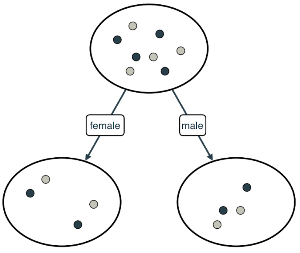

Als we de dataset splitsen op gender, dan hebben we:
- in de linker tak met waarde "female": 2 keer app 1 en 2 keer app 2
- in de rechter tak met waarde "male": 2 keer app 1 en 2 keer app 2

De Entropy voor:
- de wortel: $-\frac{4}{8}\log_2(\frac{4}{8})-\frac{4}{8}\log_2(\frac{4}{8})=1$
- het linkerblad: $-\frac{2}{4}\log_2(\frac{2}{4})-\frac{2}{4}\log_2(\frac{2}{4})=1$
- het rechterblad: $-\frac{2}{4}\log_2(\frac{2}{4})-\frac{2}{4}\log_2(\frac{2}{4})=1$

De gewogen gemiddelde Entropy van de bladeren is dan: $\frac{4}{8}1 + \frac{4}{8}1 = 1$

De Information Gain is tenslotte: $1 - 1 = 0$

*Feature Age*

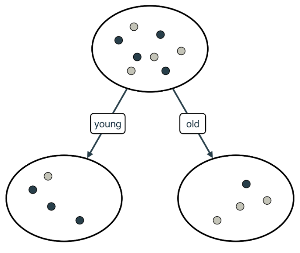

Als we de dataset splitsen op "age", dan hebben we:
- in de linker tak met waarde "young": 3 keer app 1 en 1 keer app 2
- in de rechter tak met waarde "adult": 1 keer app 1 en 3 keer app 2

De Entropy voor:
- de wortel: $-\frac{4}{8}\log_2(\frac{4}{8})-\frac{4}{8}\log_2(\frac{4}{8})=1$
- het linkerblad: $-\frac{3}{4}\log_2(\frac{3}{4})-\frac{1}{4}\log_2(\frac{1}{4})=0.81$
- het rechterblad: $=\frac{3}{4}\log_2(\frac{3}{4})-\frac{1}{4}\log_2(\frac{1}{4})=0.81$

De gewogen gemiddelde Entropy van de bladeren is dan: $\frac{4}{8}0.81 + \frac{4}{8}0.81 = 0.81$

De Information Gain is tenslotte: $1 - 0.81 = 0.19$

*Feature Location*

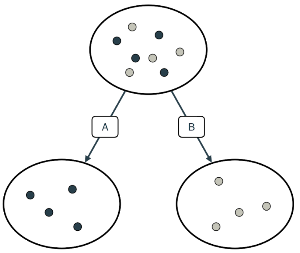

Als we de dataset splitsen op location, dan hebben we:
- in de linker tak met waarde "A": 4 keer app 1 en 0 keer app 2
- in de rechter tak met waarde "B": 0 keer app 1 en 4 keer app 2

De Entropy voor:
- de wortel: $-\frac{4}{8}\log_2(\frac{4}{8})-\frac{4}{8}\log_2(\frac{4}{8})=1$
- het linkerblad: $-\frac{4}{4}\log_2(\frac{4}{4})-\frac{0}{4}\log_2(\frac{0}{4})=0$
- het rechterblad: $-\frac{4}{4}\log_2(\frac{4}{4})-\frac{0}{4}\log_2(\frac{0}{4})=0$

De gewogen gemiddelde Entropy van de bladeren is dan:
$\frac{4}{8}0 + \frac{4}{8}0 = 0$

De Information Gain is tenslotte: $1 - 0 = 1$

*Conclusie*

De beste split volgens de Information Gain is eveneens op feature "location".

##### Opdracht

Implementeer de formules voor Information Gain en Entropy in Python. Doe dit op dezelfde manier als de implementatie voor Gini Gain. Test je code uit op de appstore dataset die is toegekend aan variabele `df`.

Starten met functie `entropy`:

In [ ]:
from math import log2  # basis 2!

def entropy(dataframe, target):
    cts = count_per_label(dataframe, target)
    n = len(dataframe)
    return  sum([-1 * a_i / n * log2(a_i / n) for a_i in cts])

Uittesten op `df` met target `'app'`:

In [ ]:
entropy(df, 'app')

1.4591479170272448

Functie `weighted_entropy`:

In [ ]:
def weighted_entropy(split, target):
    d = sum([len(s) for s in split])
    g = sum([len(s) / d * entropy(s, target) for s in split])
    return g

Testen op `df` en feature `'age'`:

In [ ]:
split = split_dataframe(df, 'age')
weighted_entropy(split, 'app')

0.4591479170272448

Functie `information_gain`:

In [ ]:
def information_gain(dataframe, split, target):
    return entropy(dataframe, target) - weighted_entropy(split, target)

Testen op `df` en feature `'age'`:

In [ ]:
information_gain(df, split, 'age')

1.0

De functie `get_best_split` gaan we ook generieker maken door de metriek voor het berekenen van de gain als inputparameter mee te geven:

In [ ]:
def get_best_split(dataframe, features, target, impurity_gain):
    result = dict()
    for feature in features:
        split = split_dataframe(dataframe, feature)
        result[impurity_gain(dataframe, split, target)] = (feature, split)
    return result[max(result.keys())]

Functie testen met `information_gain`:

In [ ]:
best_feature, split = get_best_split(df, ['age', 'gender'], 'app', information_gain)
print(best_feature)
print()
for sub in split:
    print(sub)
    print()

age

  gender    age   app
0      F  young  atom
4      M  young  atom
5      M  young  atom

  gender    age      app
1      F  adult    check
2      M  adult  beehive
3      F  adult    check



`gini_gain` geeft hetzelfde resultaat:

In [ ]:
best_feature, split = get_best_split(df, ['age', 'gender'], 'app', gini_gain)
print(best_feature)
print()
for sub in split:
    print(sub)
    print()

age

  gender    age   app
0      F  young  atom
4      M  young  atom
5      M  young  atom

  gender    age      app
1      F  adult    check
2      M  adult  beehive
3      F  adult    check



**Pandas**

We kunnen die functies efficiënter schrijven door gebruik te maken van Pandas methodes, zoals `groupby`.

Functies `gini_impurity` en `entropy`:

In [ ]:
def gini_impurity(df, target):
    # df is dataframe
    # target is name of column in df
    p = df.groupby(target).count().iloc[:, 0] / len(df)
    return 1 - np.sum(np.square(p))

In [ ]:
def entropy(df, target):
    # df is dataframe
    # target is name of column in df
    p = df.groupby(target).count().iloc[:, 0] / len(df)
    return np.sum(-p * np.log2(p))

We definiëren hier een generieke functie `gain`:

In [ ]:
def gain(df, feature, target, metric=gini_impurity):
    # df is dataframe
    # feature and target are names of column in df
    # metric is gini_impurity() or entropy()
    func = lambda subdf: metric(subdf, target) * len(subdf) / len(df)
    weighted_metrics = df.groupby(feature).apply(func)
    return metric(df, target) - weighted_metrics.sum()

Functie `get_best_split` kan ook efficiënter:

In [ ]:
def get_best_split(df, target, metric=gini_impurity):
    # df is dataframe
    # target is name of column in df
    # metric is gini_impurity() or entropy()
    features = list(df.columns)
    features.remove(target)
    i = np.argmax([gain(df, feature, target, metric) for feature in features])
    return features[i]

Uittesten:

In [ ]:
print(get_best_split(df, "app", metric=gini_impurity))
print(get_best_split(df, "app", metric=entropy))

age
age


### Round up

We herhalen hier de belangrijke vragen die we in het begin gesteld hebben en proberen die nu te beantwoorden adhv de theorie die we al besproken hebben:

- *Welke feature gebruiken we in de eerste node om een eerste opsplitsing te maken?*
- *Hoe kunnen we inschatten dat een opsplitsing in een node (en dus een keuze voor een feature) een goede keuze is?*
- *Wanneer moeten we ophouden met opsplitsen? M.a.w. wanneer zijn we in een leaf (blad) beland?*
- *Moeten we alle features gebruiken in een decision tree?*
- *Mag een feature meerdere keren gebruikt worden?*
- ...

Op de eerste twee vragen hebben we een duidelijke antwoord gegeven met de metrieken *information gain* en *entropy gain*. Om de andere vragen te beantwoorden moeten we eerst een algoritme hebben die de boom achtereenvolgens gaat splitsen mbv die metrieken.

Voordat we een algoritme bouwen om een decision tree te maken, bekijken we nog even de derde vraag.
De reden waarom we de dataset herhaaldelijk opsplitsen, is om in elke node een lage *impurity* of *entropy* te bekomen. Die informatie kunnen we ook gebruiken om te beslissen of we een node verder gaan opsplitsen, of gaan stoppen en de node als een leaf gaan gebruiken. Als de impurity of entropy in een bepaalde node zeer laag is, dan bestempelen we die node als *homogeen*. De waarde of *threshold* waarop we beslissen om een node verder te splitsen of niet, is een hyperparameter van het decision tree machine learning model.

## Algoritme "GrowTree"

Hieronder is een algoritme gegeven om een decision tree op te stellen op een dataset $D$, beschreven door features $F$.

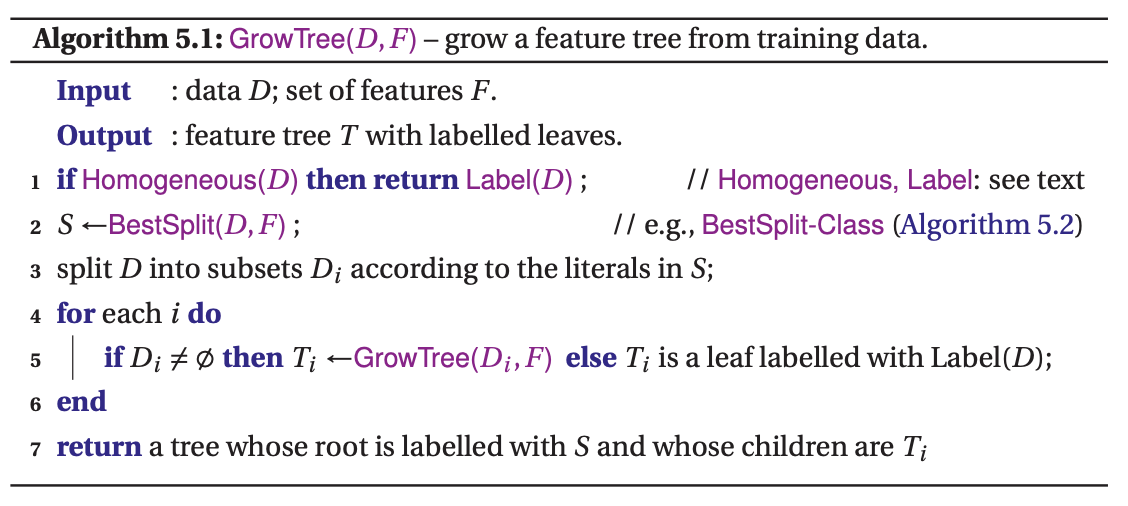

De input van het algoritme is een dataframe $D$, met een gekend target, en een featureset $F$.

Op lijn 1 bekijken we of de dataset die bij een bepaalde node hoort, al dan niet voldoende homogeen is. Indien de dataset homogeen genoeg is, dan gebruiken we die node als een leaf. De functie `label(D)` bepaalt het meest geschikte label voor een dataset.

Indien een node niet homogeen genoeg is, dan gebruiken de we het algoritme dat we in de vorige sectie gezien hebben om de beste split te zoeken (lijn 2 en 3). Voor elke child van die split herhalen we dan het algoritme (lijn 4 - 6).

We stellen dus recursief een beslissingsboom op, telkens tot een node niet meer gesplitst hoeft te worden.

Dit algoritme is een **greedy** algoritme: telkens een beslissing genomen wordt (welke split beste is op een bepaald moment), komt het algoritme daar niet meer op terug. Dit wil dus zeggen dat het algoritme niet noodzakelijk de meest optimale beslissingsboom berekent. Om toch de optimale beslissingsboom te bekomen, zou een **back-tracking algoritme** nodig zijn, dat het algoritme op 'zijn stappen doet terugkeren'. Maar dit is meestal computationeel niet haalbaar.

**Implementatie**

We geven een implementatie van dit algoritme. Eerst introduceren we een klasse `Tree` om een datastructuur voor onze beslissingsboom te voorzien. Een tree heeft volgende eigenschappen:
- `feature` is de feature waarop in die node gesplitst wordt.
- `value` is de waarde van de feature waarop in de parent van de tree gesplitst wordt.
- `label` wordt enkel gebruikt in een leaf, en is dus de feature die voorspeld wordt.
- `children` zijn de subtrees in een node. Normaal gezien is er een child per waarde die de feature kan aannemen waarop gesplitst wordt.

In [ ]:
class Tree:

    def __init__(self, feature, value=None, label=None, children=None):
        self.label = label
        self.feature = feature
        self.value = value
        self.children = children

    def is_leaf(self):
        return self.label != None

    def __repr__(self):  # string representation of Tree object
        if self.is_leaf():
            return self.value + " (Label: " + self.label + ")"
        if not self.value:
            return self.feature + " (" + " - ".join([str(c) for c in self.children]) +  ")"
        return self.value + " ; " + self.feature + " (" + " - ".join([str(c) for c in self.children]) +  ")"

De functie `homogenous` berekent voor een gegeven dataset `dataframe` en gegeven `target` of de dataset homogeen genoeg is om één label te beschrijven. Er zijn twee default parameters die de impurity functie en de threshold voorstellen die gebruikt moeten worden om de beslissing te nemen.

In [ ]:
def homogeneous(dataframe, target, impurity_gain=gini_impurity, threshold=0.2):
    if (impurity_gain(dataframe, target) < threshold):
        return True
    return False

Uittesten op de volledige appstore dataset `df`:

In [ ]:
homogeneous(df, 'app')

False

Uittesten op de eerste split op `'age'`:

In [ ]:
split = split_dataframe(df, 'age')
homogeneous(split[0], 'app')

True

De functie `label` berekent voor een gegeven dataframe en target welke label het best gebruikt kan worden voor de dataset. Hiervoor gebruiken we het *majority class labeling* principe dat we eerder gezien hebben.

In [ ]:
def label(dataframe, target):
    # majority class
    classes = dict()
    for element in dataframe[target]:
        if element in classes:
            classes[element] += 1
        else:
            classes[element] = 1
    return max(classes, key=classes.get)

Opnieuw uittesten op `df`:

In [ ]:
label(df, 'app')

'atom'

Dat kan ook via Pandas methodes:

In [ ]:
target = 'app'
counts = df[target].value_counts()
counts.index[counts.argmax()]

'atom'

De functie `grow_tree` implementeert het recursieve algoritme om de beslissingsboom op de stellen.

In [ ]:
def grow_tree(dataframe, features, target, impurity_gain=gini_gain):
    if homogeneous(dataframe, target):
        return Tree(target, label=label(dataframe, target))
    feature, split = get_best_split(dataframe, features, target, impurity_gain)
    children = [(s, grow_tree(s, features, target)) for s in split]
    subtrees = []
    for s, child in children:
        child.value = s[feature].unique()[0]
        subtrees.append(child)
    return Tree(feature, children=subtrees)

Laten we dat nu eens testen op de appstore dataset:

In [ ]:
tree = grow_tree(df, ['gender', 'age'], 'app')
tree

age (young (Label: atom) - adult ; gender (F (Label: check) - M (Label: beehive)))

Eerst wordt dus op feature `'age'` gesplitst:

In [ ]:
tree.feature

'age'

Er zijn twee children:

In [ ]:
for child in tree.children:
    print(child)

young (Label: atom)
adult ; gender (F (Label: check) - M (Label: beehive))


`tree.children[0]` met value `'young'` is een leaf met label `'atom'`:

In [ ]:
tree.children[0].value, tree.children[0].label

('young', 'atom')

`tree.children[1]` heeft zelf 2 children voor values `'F'` en `'M'` met labels `'check'` en `'beehive'`, respectievelijk:

In [ ]:
for child in tree.children[1].children:
    print(child)

F (Label: check)
M (Label: beehive)


## Decision trees in Scikit-Learn

In plaats van zelf algoritmes te schrijven, kunnen we in de praktijk uiteraard beter gebruik maken van bestaande code in bijv. Scikit-Learn. Er is een module `sklearn.tree`, en die bevat de `DecisionTreeClassifier` klasse.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import random
random.seed(0)

Merk op dat we de `seed` initialiseren van module `random`. Dat doen we om dezelfde resultaten te krijgen in deze notebook. In praktijk ga je natuurlijk de "randomness" zijn werk laten doen en definieer je om die reden geen `seed`!

We gebruiken de data in de volgende dataframe.

In [ ]:
app_data = pd.DataFrame({
    'Gender': ['Female','Female','Male','Female','Male','Male'],
    'Age': [15, 25, 32, 35, 12, 14],
    'App': ['Atom Count', 'Check Mate', 'Beehive Finder', 'Check Mate', 'Atom Count', 'Atom Count']})

app_data

,Gender,Age,App
0,Female,15,Atom Count
1,Female,25,Check Mate
2,Male,32,Beehive Finder
3,Female,35,Check Mate
4,Male,12,Atom Count
5,Male,14,Atom Count


We transformeren de feature `'Age'` in een binaire feature: alle personen jongern dan 20 zijn `'young'`, de rest zijn `'adult'`.

In [ ]:
young = app_data['Age'] < 20
app_data.loc[young, 'Age'] = 'young'
app_data.loc[~young, 'Age'] = 'adult'
app_data

,Gender,Age,App
0,Female,young,Atom Count
1,Female,adult,Check Mate
2,Male,adult,Beehive Finder
3,Female,adult,Check Mate
4,Male,young,Atom Count
5,Male,young,Atom Count


We selecteren de features waarop we onze decision tree willen trainen:

In [ ]:
features = app_data[['Gender', 'Age']]

De classifier in sklearn kan niet omgaan met categorische data zoals in de dataframe met de features. We zullen de features moeten encoderen naar integers. We gebruiken daarvoor de `OrdinalEncoder` van sklearn.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc_features = OrdinalEncoder()
enc_features.fit(features)
X = enc_features.transform(features)
print(X)

[[0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]]


De categorieën kan je opvragen:

In [ ]:
enc_features.categories_

[array(['Female', 'Male'], dtype=object),
 array(['adult', 'young'], dtype=object)]

En je kan ook de volgorde van de features opvragen, wat straks handig zal zijn bij het plotten van de decision tree:

In [ ]:
enc_features.feature_names_in_

array(['Gender', 'Age'], dtype=object)

We selecteren de target feature en gemakkelijkheidshalve gaan we die ook encoderen:

In [ ]:
label = app[['App']]  # moet 2D zijn!
enc_label = OrdinalEncoder()
enc_label.fit(label)
y = enc_label.transform(label)
y

array([[0.],
       [2.],
       [1.],
       [2.],
       [0.],
       [0.]])

Vervolgens trainen we een decision tree op basis van de features en het target:

In [ ]:
app_model = DecisionTreeClassifier()
tree = app_model.fit(X, y)

De nauwkeurigheid is uiteraard 100% voor deze eenvoudige dataset:

In [ ]:
tree.score(X, y)

1.0

We plotten de getrainde decision tree:

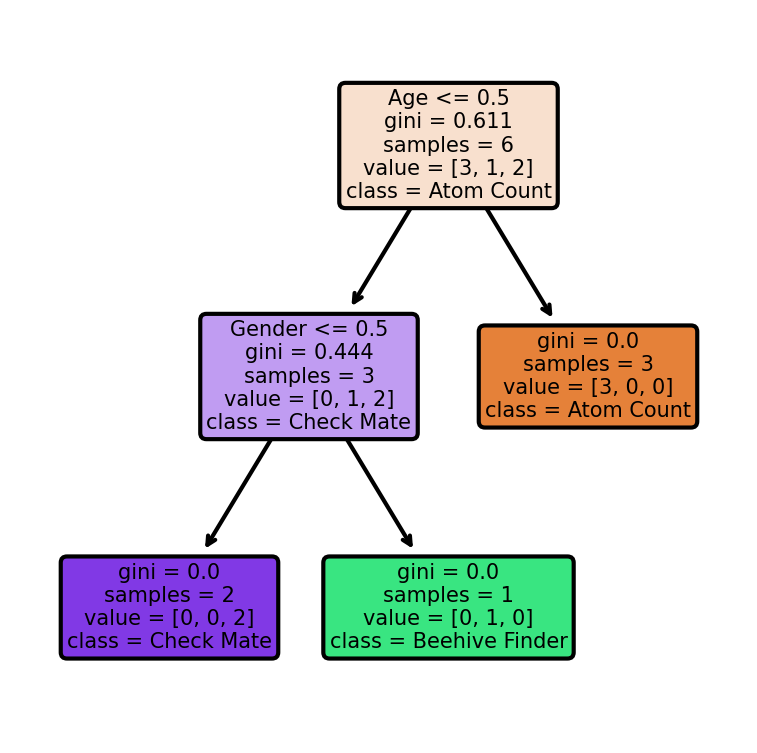

In [ ]:
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
plot_tree(tree,
          feature_names=enc_features.feature_names_in_,
          class_names=enc_label.categories_[0],
          filled=True, fontsize=5, rounded=True);

Door de encoding zien we de eigenlijke waarden niet meer voor de features `'Age'` en `'Gender'`, maar de indices kunnen we terugvinden in attribuut `categories_` van de encoder, zoals we daarnet zagen:
- voor `'Gender'` is  `0` gelijk aan `'Female'` en `1` gelijk aan `'Male'`;
- voor `'Age'` is `0` gelijk aan `'adult'`, en `1` gelijk aan `'young'`.

Tenslotte maken we een aantal voorspellingen met behulp van het decision tree model voor enkele nieuwe data:

In [ ]:
Xnew = [[0, 1],   # Female young
        [1, 0],   # Male adult
        [1, 1]]   # Male young

ypred = tree.predict(Xnew)
print(ypred)

print(enc_label.categories_[0][ypred.astype(int)])

[0. 1. 0.]
['Atom Count' 'Beehive Finder' 'Atom Count']


## Opdracht

Lees de file `simpsons.csv` in. Stel een beslissingsboom die gebruik makend van alle features het 'geslacht' voorspelt. Plot de beslissingsboom. Print de voorspelde en de echte labels uit en vergelijk. Evalueer het model door de nauwkeurigheid te berekenen. Maak gebruik van sklearn.

In [ ]:
# import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# dataset inlezen
simpsons = pd.read_csv('simpsons.csv')
simpsons

,haarlengte,gewicht,leeftijd,geslacht
0,<3,>160,30-40,M
1,>5,<=160,30-40,V
2,<3,<=160,<30,M
3,>5,<=160,<30,V
4,3-5,<=160,<30,V
5,<3,>160,>40,M
6,>5,<=160,>40,V
7,>5,>160,30-40,M
8,>5,>160,>40,M


In [ ]:
# features en labels
features = simpsons[['haarlengte', 'gewicht', 'leeftijd']]
label = simpsons[['geslacht']]

In [ ]:
# ordinal encoding toepassen op de features
enc_features = OrdinalEncoder()
enc_features.fit(features)
X = enc_features.transform(features)
print(X)

[[1. 1. 0.]
 [2. 0. 0.]
 [1. 0. 1.]
 [2. 0. 1.]
 [0. 0. 1.]
 [1. 1. 2.]
 [2. 0. 2.]
 [2. 1. 0.]
 [2. 1. 2.]]


In [ ]:
# ordinal encoding toepassen op de labels
enc_label = OrdinalEncoder()
enc_label.fit(label)
y = enc_label.transform(label)
print(y)

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [ ]:
# het model trainen
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

In [ ]:
# voorspelde en echte labels uitprinten
yp = clf.predict(X)
pred = enc_label.categories_[0][yp.astype(int)]
print(label.values.squeeze())
print(pred)

['M' 'V' 'M' 'V' 'V' 'M' 'V' 'M' 'M']
['M' 'V' 'M' 'V' 'V' 'M' 'V' 'M' 'M']


In [ ]:
# accuracy is 100%
clf.score(X, y)

1.0

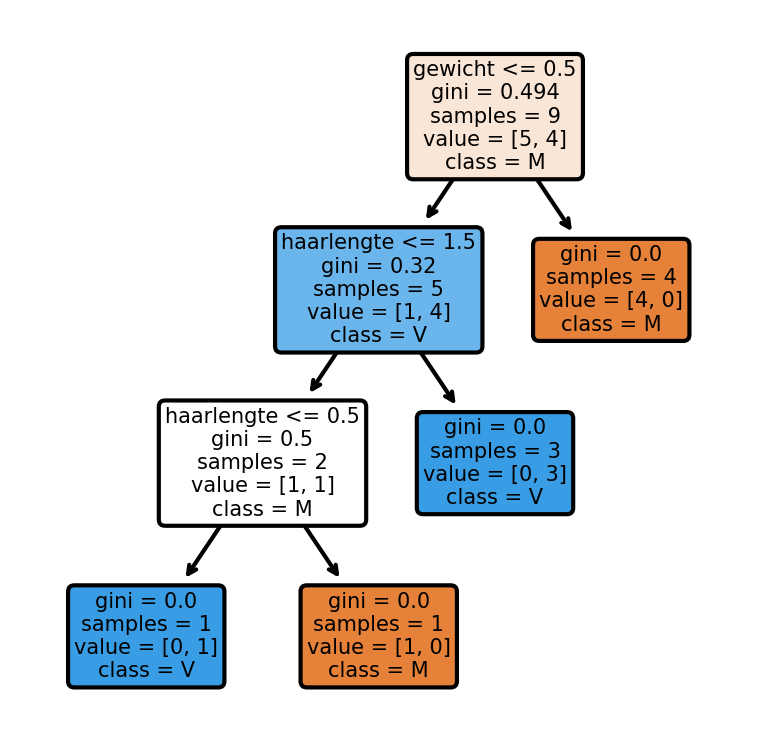

In [ ]:
# beslissingsboom plotten
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
plot_tree(clf,
          feature_names=enc_features.feature_names_in_,
          class_names=enc_label.categories_[0],
          filled=True, fontsize=5, rounded=True);

---



---
## BRONNEN
* Handboek: Grokking Machine Learning (version 12), Manning Early Access Program, by Luis G. Serrano, 2020.
* Machine Learning: The Art and Science of Algorithms that Make Sense of Data, Peter Flach, 2019.

---